In [1]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import minimize
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/LMatt/OneDrive/Dokumente/Mathe/Machine Learning/Projekt/digits_train.csv')

In [3]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100
#dimensionserhoehung, damit am ende b = 0
train_images = np.concatenate((train_images, np.ones((len(train_images),1))), axis = 1)

train_labels = np.array(train['label'])
label0 = np.array([1 if i==0 else -1 for i in train_labels])
len(train_images)

42000

In [4]:
#mal gucken, wie weit die Datenpunkte so ungefähr auseinander liegen, damit wir wissen wie groß sigma sein muss
np.linalg.norm(train_images[130] - train_images[6])

28.478958899510353

In [59]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-sigma*np.linalg.norm(x1-x2)**2)

def gk(x1,x2):
    sigma = float(1)/100
    return gaussian_kernel(x1, x2, sigma)

def scalar_product(x1, x2):
    return np.dot(x1, x2)

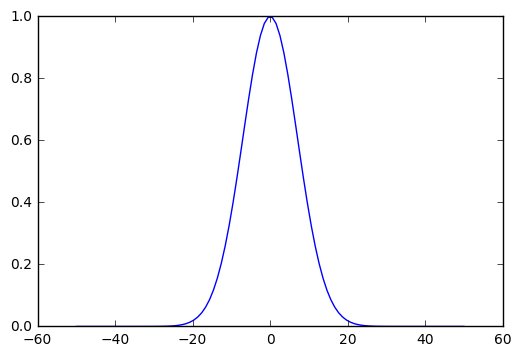

In [60]:
plt.figure()
x = np.linspace(-50, 50, 100)
y = [gk(0,i) for i in x]
plt.plot(x, y)

In [7]:
def minimize_Lagrangian(training_data, training_labels, penalty, kernel):
    no_samples = len(training_data)
    t = np.diag(training_labels[:no_samples])
    tm = -t
    K = matrix(pairwise_kernels(training_data, metric = kernel),tc='d')
    p = matrix(training_labels,tc='d')
    A = matrix(1., ( 1,no_samples),tc='d')
    b = matrix(0.,(1,1),tc='d')
    G = matrix(np.concatenate((tm,t)),tc='d')
    h = matrix(np.concatenate((matrix(0.,(no_samples,1 )), matrix(float(penalty),(no_samples,1)))),tc='d')
    sol = solvers.qp(-K, p, G, h, A, b)
    x = np.reshape(np.array(sol['x']), no_samples)
    a = np.array([x[i]*training_labels[i] for i in range(no_samples)])
    return a

In [8]:
def assemble_kernelmatrix(data, data2 = None, kernel = scalar_product):
    if data2 == None:
        K = pairwise_kernels(data, metric = kernel)
    else:
        K = pairwise_kernels(data2, data, metric = kernel)
    return K

def minimize_Lagrangian2(training_data, training_labels, penalty, kernel, kernelmatrix):
    no_samples = len(training_data)
    training_labels = matrix(training_labels, (no_samples, 1))
    K = kernelmatrix
    T = np.dot(training_labels, np.transpose(training_labels))
    Q = matrix(np.multiply(K, T), (no_samples, no_samples), tc='d')
    A = matrix(training_labels, ( 1, no_samples),tc='d')
    print(np.shape(A))
    p = matrix(-1., ( no_samples, 1),tc='d')
    b = matrix(0.,(1,1),tc='d')
    G = matrix(np.concatenate((-np.identity(no_samples),np.identity(no_samples))),tc='d')
    h = matrix(np.concatenate((matrix(0.,(no_samples,1 )), matrix(float(penalty),(no_samples,1)))),tc='d')
    sol = solvers.qp(Q, p, G, h, A, b)
    a = np.reshape(np.array(sol['x']), no_samples)
    return a 

In [9]:
def minimize_Lagrangian3(training_data, training_labels, penalty, kernel):

    no_samples = len(training_data)
    K = pairwise_kernels(training_data, metric = kernel)
    def Lagrangian(x):
        return 0.5*np.dot(np.dot(np.transpose(x),Q),x) - np.dot(np.transpose(p),x)
    T = np.dot(training_labels, np.transpose(training_labels))
    Q = np.multiply(K, T)
    A = training_labels
    p = np.ones(no_samples)
    b = np.array(0.)
    G = np.concatenate((-np.identity(no_samples),np.identity(no_samples)))
    h = np.concatenate((np.zeros(no_samples), penalty*np.ones(no_samples)))
    '''K = np.array(K)
    q = np.array(q)
    A = np.array(A)
    b = np.array(b)
    G = np.array(G)
    h = np.array(h)'''
    a0 = np.zeros((no_samples, 1))
    constraint1 = {'type': 'ineq',
                  'fun': lambda x: -np.dot(G,x)+h,
                  'jac': lambda x: -G}
    constraint2 ={'type': 'eq',
                 'fun': lambda x: np.dot(A,x)+b,
                 'jac': lambda x: A}
    options = {'maxiter': 100000}
    a=scipy.optimize.minimize(Lagrangian, a0, constraints=[constraint1, constraint2], jac = lambda x: np.dot(Q,x), hess = lambda x: Q,method = 'Powell', options = options)
    return a


In [10]:
C = 1000
daten = np.array([[0,1], [1, 0],[2,0], [1,2], [0, 0.9]])
labels = np.array([-1, 1, 1, -1, 1])
a = minimize_Lagrangian2(daten, labels, C, scalar_product)
a

TypeError: minimize_Lagrangian2() takes exactly 5 arguments (4 given)

In [12]:
no_samples = 100
C = 1000
data = train_images[:no_samples]
label = np.array(label0[:no_samples])
a = minimize_Lagrangian2(data, label, C, scalar_product)
a


TypeError: minimize_Lagrangian2() takes exactly 5 arguments (4 given)

In [120]:
class mySVM:
    
    def __init__(self, kernel = gk, penalty = 1, sigma = 0.01):
        self.sigma = sigma
        self.kernel = kernel
        self.penalty = penalty
        self.kernelmatrix_for_fit = None
        self.kernelmatrix_for_predict = None
        
    def fit(self,training_data, training_labels):
        if self.kernelmatrix_for_fit == None:
            self.kernelmatrix_for_fit  = assemble_kernelmatrix(training_data, kernel = self.kernel)
        a = minimize_Lagrangian2(training_data, training_labels,self.penalty, self.kernel, kernelmatrix = self.kernelmatrix_for_fit)    
        self.a = a
        self.training_data = training_data
        self.training_labels = training_labels

        
    def predict(self, newdata):
        if self.kernelmatrix_for_predict == None:
            self.kernelmatrix_for_predict = assemble_kernelmatrix(self.training_data, data2 = newdata, kernel = self.kernel)
        k = self.kernelmatrix_for_predict
        alphatimeslabel = np.multiply(self.a, self.training_labels)
        prediction = np.array([np.dot(k[i,:], alphatimeslabel) for i in range(len(newdata))])
        return np.sign(prediction)
    
        

In [122]:
C=1
no = 100 #Anzahl an Trainingsdaten, die zum fitten verwendet werden
no2 = 100 #Anzahl an Trainingsdaten, die nicht zum fitten verwendet wurden, mit denen wir unsere SVM testen
s = 0.0001
svm = mySVM(kernel = gk, penalty=C, sigma = s )
svm.fit(train_images[:no], train_labels[:no])
pred = svm.predict(train_images[:no+no2])
x = list(pred == label0[:no+no2])
sum(x[:no]), sum(x[-no2:])
#[svm.a[i] for i in range(no) if label0[i]==-1]

(1L, 100L)
     pcost       dcost       gap    pres   dres
 0: -1.0996e+01 -1.2263e+02  4e+02  1e+00  5e-16
 1: -9.2065e+00 -5.0377e+01  5e+01  8e-02  5e-16
 2: -1.0147e+01 -2.8436e+01  3e+01  3e-02  1e-15
 3: -9.3626e+00 -1.3769e+01  7e+00  7e-03  7e-15
 4: -9.0281e+00 -9.2392e+00  4e-01  3e-04  3e-15
 5: -9.0003e+00 -9.0024e+00  4e-03  3e-06  4e-15
 6: -9.0000e+00 -9.0000e+00  4e-05  3e-08  3e-15
 7: -9.0000e+00 -9.0000e+00  4e-07  3e-10  3e-15
Optimal solution found.


C:\Users\LMatt\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


(68, 45)

(array([37, 54,  0,  0,  0,  0,  0,  0,  0,  9], dtype=int64),
 array([ 0.00171607,  0.10154446,  0.20137285,  0.30120124,  0.40102964,
         0.50085803,  0.60068642,  0.70051481,  0.80034321,  0.9001716 ,
         0.99999999]))

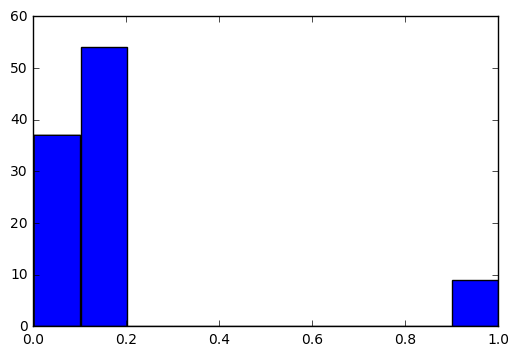

In [144]:
plt.hist(svm2.a)
np.histogram(svm2.a)

In [140]:
svm2 = mySVM(kernel = gk, penalty=C, sigma = s )
svm2.fit(train_images[:no], label0[:no])


(1L, 100L)
     pcost       dcost       gap    pres   dres
 0: -1.3653e+01 -1.4967e+02  6e+02  2e+00  5e-16
 1: -1.2523e+01 -6.9010e+01  6e+01  2e-02  5e-16
 2: -1.2495e+01 -1.3673e+01  1e+00  3e-04  5e-16
 3: -1.2585e+01 -1.2642e+01  6e-02  7e-06  1e-16
 4: -1.2590e+01 -1.2594e+01  3e-03  3e-07  7e-17
 5: -1.2591e+01 -1.2591e+01  2e-04  1e-08  8e-17
 6: -1.2591e+01 -1.2591e+01  1e-05  2e-10  1e-16
Optimal solution found.


In [145]:
a= np.array([0 if alpha<10**(-2) else alpha for alpha in svm2.a])

svm2.a = a
pred = svm2.predict(train_images[:no+no2])
x = list(pred == label0[:no+no2])
sum(x[:no]), sum(x[-no2:])
print(pred)
[label0[i] for i in range(100) if not a[i]==0]

[-1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1.
 -1. -1.]


C:\Users\LMatt\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[-1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1]

In [136]:

svm2.kernelmatrix_for_predict


array([[  1.00000000e+00,   1.77260721e-05,   7.31712345e-03, ...,
          1.90201980e-04,   5.19817900e-04,   7.06048302e-05],
       [  1.77260721e-05,   1.00000000e+00,   3.05014602e-05, ...,
          7.82559970e-04,   8.25062921e-05,   1.92963019e-04],
       [  7.31712345e-03,   3.05014602e-05,   1.00000000e+00, ...,
          2.33936698e-04,   4.21375583e-04,   7.62116668e-05],
       ..., 
       [  1.32510059e-04,   2.68179264e-05,   4.32307248e-04, ...,
          9.59979232e-05,   5.22001077e-05,   3.29848564e-05],
       [  3.00030026e-04,   1.83875805e-04,   4.60813109e-04, ...,
          1.26363738e-04,   1.51239648e-05,   3.20720029e-04],
       [  6.05561705e-03,   4.49723366e-05,   1.12655497e-03, ...,
          5.91032825e-04,   9.98584375e-05,   1.71068756e-04]])

In [175]:
no = 1000
images0 = []
imagesnot0 = []
i = 0
while len(images0)<no/2. or len(imagesnot0) < no/2.:
    if label0[i]==1 and len(images0)<no/2.:
        images0.append(train_images[i])
    elif label0[i]==-1 and len(imagesnot0) < no/2.: 
        imagesnot0.append(train_images[i])
    i=i+1
print(len(images0))
trainingdata_even = np.concatenate((np.array(images0), np.array(imagesnot0)))
traininglabels_even = np.concatenate((np.ones(len(images0)), -np.ones(len(imagesnot0))))

500


In [178]:

svm3=mySVM(kernel = gk, penalty=C, sigma = s )
svm3.fit(trainingdata_even, traininglabels_even)

(1L, 1000L)
     pcost       dcost       gap    pres   dres
 0: -1.8275e+02 -1.7319e+03  5e+03  2e+00  1e-15
 1: -1.7000e+02 -9.2010e+02  8e+02  3e-13  5e-16
 2: -1.9212e+02 -2.6820e+02  8e+01  1e-13  5e-16
 3: -1.9912e+02 -2.0761e+02  8e+00  7e-14  4e-16
 4: -2.0009e+02 -2.0147e+02  1e+00  1e-13  3e-16
 5: -2.0026e+02 -2.0057e+02  3e-01  2e-13  3e-16
 6: -2.0030e+02 -2.0035e+02  5e-02  2e-14  3e-16
 7: -2.0031e+02 -2.0031e+02  3e-03  2e-13  3e-16
 8: -2.0031e+02 -2.0031e+02  9e-05  2e-13  3e-16
Optimal solution found.


In [181]:
a= np.array([0 if alpha<10**(-3) else alpha for alpha in svm3.a])
svm3.a = a
pred = svm3.predict(train_images[:no])
x = list(pred == label0[:no])
print(a)
sum(x[:no])


[ 0.14852741  0.10761196  0.75563507  0.          0.35504448  0.
  0.19501527  0.71335371  0.40388899  0.25922856  0.40162857  0.23366651
  0.32560425  0.94098657  0.57510225  0.43394686  0.82295792  0.23111014
  0.05528104  0.86596139  0.          0.27683956  0.36228964  0.12955513
  0.02141471  0.8933276   0.06539517  0.44510457  0.56350914  0.99999927
  0.38811404  0.39178541  0.16021827  0.          0.06290882  0.
  0.76978805  0.37878446  0.56912868  0.49910508  0.          0.20274561
  0.7743776   0.43242211  0.22066152  0.2835847   0.          0.27339149
  0.70915287  0.          0.65847064  0.          0.24278906  0.3139659
  0.02346468  0.16795367  0.00700537  0.69310127  0.19948181  0.3503308
  0.31985193  0.71025483  0.79268244  0.09804262  0.82773451  0.25022565
  0.          0.49172355  0.66373345  0.26733185  0.73459374  0.73717449
  0.34885283  0.65556657  0.80719062  0.456559    0.          0.          0.1615302
  0.63673793  0.54519339  0.436833    0.06699522  0.312090

C:\Users\LMatt\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


983

In [167]:
np.shape(trainingdata_even)

(100L, 785L)